#SPDX-FileCopyrightText: 2024 David Fernandes del Pozo <david.fernandesdelpozo@ugent.be>, <fernandesdelpozo.david@gmail.com>

#SPDX-License-Identifier: GPL-3.0

# Numerical verification of the Tacáks settler model

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import ode
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

# Prints current Python version
print("Current version of Python is ", sys.version)
print("Current version of Scipy is ", scipy.__version__)


# Change some matplotlib settings
plt.rcParams
matplotlib.rcdefaults()
plt.rcParams['mathtext.fontset'] = "cm"

Current version of Python is  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Current version of Scipy is  1.11.1


In [2]:
# Model Parameters Retrieved from BSM1
v0_max = 250        # Maximum settling velocity               [m/d]
v0     = 474        # Maximum Vesilind settling velocity      [m/d]
rh     = 0.000576   # Hindered zone settling parameter        [m³/(gSS)]
rp     = 0.00286    # Flocculant zone settling parameter      [m³/(gSS)]
fns    = 0.00228    # Non-settable fraction                   [-]

Xt     = 3000       # Threshold concentration                 [g/m³]
Qo     = 36892      # Flow rate                               [m³/d]
Qe     = 18061      # Flow rate                               [m³/d]
Qs     = 18831      # Flow rate                               [m³/d]
A      = 1500       # Crossectional area of the settler       [m²]
zm     = 0.4        # Height of each layer                    [m]
V      = 6000       # Volume of the settler                   [m³]
v_up   = Qe/A       # Upward velocity                         [m/d]
v_dn   = Qs/A       # Downward velocity                       [m/d]

In [3]:
# Steady-State values of all particulate matter
XI5   = 1149.1182   #                                         [g COD/m³]
XS5   = 49.3056     #                                         [g COD/m³]
XBH5  = 2559.341    #                                         [g COD/m³]
XBA5  = 149.7963    #                                         [g COD/m³]
XP5   = 452.2051    #                                         [g COD/m³]
XND5  = 3.5272      #                                         [g N/m³]

# COD to SS conversion factor
frCOD_SS = 4/3

# Calculate the sludge concentration from the concentrations in compartment 5 of the 
# activated sludge reactor
Xo = 1/frCOD_SS*(XI5 + XS5 + XBH5 + XBA5 + XP5) # = 3269.82 --> Xstab
Xmin = fns * Xo     # =7.45 g/m³ 

# Initial concentration in each layer
X0 = np.zeros(10)
X0[5] = 0        

### Solving with ODE

In [4]:
############################ Settler Model ################################## 
def derivatives_settler(t,X):
    # Define the settling flux
    Js = []
    for j in range(len(X)):
        # Settling flux current layer
        Js_cl = max(0, min(v0_max, v0*(np.exp(-rh*(X[j]-Xmin)) - np.exp(-rp*(X[j]-Xmin))))) * X[j]  
        # Settling flux previous layer 
        Js_pl = max(0, min(v0_max, v0*(np.exp(-rh*(X[j-1]-Xmin)) - np.exp(-rp*(X[j-1]-Xmin))))) * X[j-1]
        if j < 7:
            Js.append(Js_cl)
        else: 
            Js.append(min(Js_cl, Js_pl))
    # Mass balances across settler layers
    dXdt = np.zeros(10) 
                
    dXdt[0] = 1/zm*(v_dn*(X[1]-X[0])+min(Js[0], Js[1])) 
    dXdt[1] = 1/zm*(v_dn*(X[2]-X[1])+min(Js[1], Js[2])-min(Js[1], Js[0]))
    dXdt[2] = 1/zm*(v_dn*(X[3]-X[2])+min(Js[2], Js[3])-min(Js[2], Js[1]))
    dXdt[3] = 1/zm*(v_dn*(X[4]-X[3])+min(Js[3], Js[4])-min(Js[3], Js[2]))
    dXdt[4] = 1/zm*(v_dn*(X[5]-X[4])+min(Js[4], Js[5])-min(Js[4], Js[3]))
    dXdt[5] = 1/zm*((Qo*Xo)/A-(v_up+v_dn)*X[5] + Js[6]-min(Js[5], Js[4]))
    dXdt[6] = 1/zm*(v_up*(X[5]-X[6])+Js[7] - Js[6])
    dXdt[7] = 1/zm*(v_up*(X[6]-X[7])+Js[8] - Js[7])
    dXdt[8] = 1/zm*(v_up*(X[7]-X[8])+Js[9] - Js[8])
    dXdt[9] = 1/zm*(v_up*(X[8]-X[9])-Js[9])
    
    return dXdt
##############################################################################

### Solving with ```ODE``` solver

In [5]:
#------------------------------ODE SOLVER-----------------------------------
#set time information
dt      = 0.01      # [d]
tStart  = 0.0       # [d]
tEnd    = 10 #tmax  # [d]
time    = np.arange(tStart,tEnd,dt)

# Solver
# Set up the ODE integrator
r = ode(derivatives_settler) #ode(function, y, args)
r.set_integrator("vode",
                 method="bdf",
               with_jacobian=False)
r.set_initial_value(X0, tStart)

settler_data_ode = pd.DataFrame(columns=["time", 
                                 "X1", "X2", "X3", "X4", "X5", 
                                 "X6", "X7", "X8", "X9", "X10",],
                        index=range(0, int((tEnd-tStart)/dt)), 
                        dtype='float')

# Store initial values
settler_data_ode.loc[0] = [r.t] + [r.y[j] for j in range(len(r.y))]

# Initialise counter
i = 0

while r.successful() and r.t < tEnd:
    # Advance integrator step
    r.integrate(r.t+dt)

    # Store data
    settler_data_ode.loc[i] = [r.t] + [r.y[j] for j in range(len(r.y))]

    # Update counter
    i += 1

print('X1:{:.2f}, X2:{:.2f}, X3:{:.2f}, X4:{:.2f}, X5:{:.2f}, X6:{:.2f}, X7:{:.2f}, X8:{:.2f}, X9:{:.2f}, X10:{:.2f}'.format( \
              settler_data_ode['X1'].iloc[-1],
              settler_data_ode['X2'].iloc[-1],
              settler_data_ode['X3'].iloc[-1],
              settler_data_ode['X4'].iloc[-1],
              settler_data_ode['X5'].iloc[-1],
              settler_data_ode['X6'].iloc[-1],
              settler_data_ode['X7'].iloc[-1],
              settler_data_ode['X8'].iloc[-1],
              settler_data_ode['X9'].iloc[-1],
              settler_data_ode['X10'].iloc[-1]))

X1:6393.96, X2:356.07, X3:356.07, X4:356.07, X5:356.07, X6:356.07, X7:68.98, X8:29.54, X9:18.11, X10:12.50


## Solving with ```solve_ivp``` solver

In [6]:
# Set time information
tStart = 0        # [d]
tEnd   = 10  #tmax # [d]

sol = solve_ivp(derivatives_settler, (tStart, tEnd), X0, method='BDF')#,first_step=1e-4,max_step=1e-4,rtol=1e-8, atol=1e-10

settler_data_ivp = pd.DataFrame(columns=["time", 
                                   "X1", "X2", "X3", "X4", "X5", "X6","X7", "X8", "X9", "X10",],
                        dtype='float')

settler_data_ivp['time'] = sol.t

for col_index,col in enumerate(settler_data_ivp.columns[1:]):
    settler_data_ivp[col] = sol.y[col_index,:]

#settler_data_ivp["X1"].iloc[-1]
print('X1:{:.2f}, X2:{:.2f}, X3:{:.2f}, X4:{:.2f}, X5:{:.2f}, X6:{:.2f}, X7:{:.2f}, X8:{:.2f}, X9:{:.2f}, X10:{:.2f}'.format( \
              settler_data_ivp['X1'].iloc[-1],
              settler_data_ivp['X2'].iloc[-1],
              settler_data_ivp['X3'].iloc[-1],
              settler_data_ivp['X4'].iloc[-1],
              settler_data_ivp['X5'].iloc[-1],
              settler_data_ivp['X6'].iloc[-1],
              settler_data_ivp['X7'].iloc[-1],
              settler_data_ivp['X8'].iloc[-1],
              settler_data_ivp['X9'].iloc[-1],
              settler_data_ivp['X10'].iloc[-1]))    

X1:6393.96, X2:356.07, X3:356.07, X4:356.07, X5:356.07, X6:356.07, X7:68.98, X8:29.54, X9:18.11, X10:12.50


<Figure size 640x480 with 0 Axes>

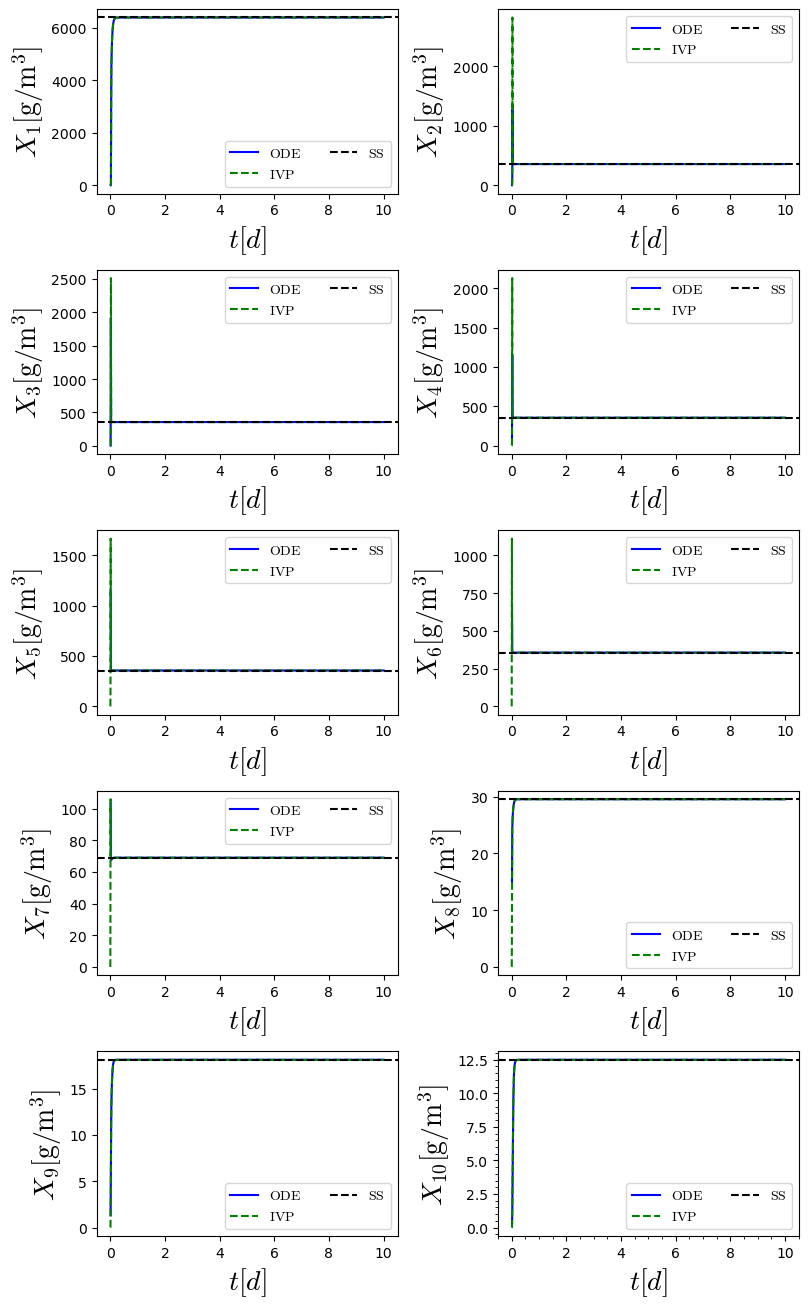

In [7]:
plt.figure()

fig, axs = plt.subplots(5, 2, figsize=(8,13))
plt.minorticks_on()

axs[0,0].plot(settler_data_ode["time"][:], settler_data_ode["X1"][:],'b-',label=r'$\mathrm{ODE}$')
axs[0,0].plot(settler_data_ivp["time"][:], settler_data_ivp["X1"][:],'g--',label=r'$\mathrm{IVP}$')
axs[0,0].axhline(6394, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[0,0].legend(fontsize=10, ncol=2)
axs[0,0].set_xlabel(r'$t [d]$', fontsize=20)
axs[0,0].set_ylabel(r'$X_1 \mathrm{[g/m^3]}$', fontsize=20)

axs[0,1].plot(settler_data_ode["time"][:], settler_data_ode["X2"][:],'b-',label=r'$\mathrm{ODE}$')
axs[0,1].plot(settler_data_ivp["time"][:], settler_data_ivp["X2"][:],'g--',label=r'$\mathrm{IVP}$')
axs[0,1].axhline(356, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[0,1].legend(fontsize=10, ncol=2)
axs[0,1].set_xlabel(r'$t [d]$', fontsize=20)
axs[0,1].set_ylabel(r'$X_2 \mathrm{[g/m^3]}$', fontsize=20)

axs[1,0].plot(settler_data_ode["time"][:], settler_data_ode["X3"][:],'b-',label=r'$\mathrm{ODE}$')
axs[1,0].plot(settler_data_ivp["time"][:], settler_data_ivp["X3"][:],'g--',label=r'$\mathrm{IVP}$')
axs[1,0].axhline(356, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[1,0].legend(fontsize=10, ncol=2)
axs[1,0].set_xlabel(r'$t [d]$', fontsize=20)
axs[1,0].set_ylabel(r'$X_3 \mathrm{[g/m^3]}$', fontsize=20)

axs[1,1].plot(settler_data_ode["time"][:], settler_data_ode["X4"][:],'b-',label=r'$\mathrm{ODE}$')
axs[1,1].plot(settler_data_ivp["time"][:], settler_data_ivp["X4"][:],'g--',label=r'$\mathrm{IVP}$')
axs[1,1].axhline(356, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[1,1].legend(fontsize=10, ncol=2)
axs[1,1].set_xlabel(r'$t [d]$', fontsize=20)
axs[1,1].set_ylabel(r'$X_4 \mathrm{[g/m^3]}$', fontsize=20)

axs[2,0].plot(settler_data_ode["time"][:], settler_data_ode["X5"][:],'b-',label=r'$\mathrm{ODE}$')
axs[2,0].plot(settler_data_ivp["time"][:], settler_data_ivp["X5"][:],'g--',label=r'$\mathrm{IVP}$')
axs[2,0].axhline(356, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[2,0].legend(fontsize=10, ncol=2)
axs[2,0].set_xlabel(r'$t [d]$', fontsize=20)
axs[2,0].set_ylabel(r'$X_5 \mathrm{[g/m^3]}$', fontsize=20)

axs[2,1].plot(settler_data_ode["time"][:], settler_data_ode["X6"][:],'b-',label=r'$\mathrm{ODE}$')
axs[2,1].plot(settler_data_ivp["time"][:], settler_data_ivp["X6"][:],'g--',label=r'$\mathrm{IVP}$')
axs[2,1].axhline(356, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[2,1].legend(fontsize=10, ncol=2)
axs[2,1].set_xlabel(r'$t [d]$', fontsize=20)
axs[2,1].set_ylabel(r'$X_6 \mathrm{[g/m^3]}$', fontsize=20)

axs[3,0].plot(settler_data_ode["time"][:], settler_data_ode["X7"][:],'b-',label=r'$\mathrm{ODE}$')
axs[3,0].plot(settler_data_ivp["time"][:], settler_data_ivp["X7"][:],'g--',label=r'$\mathrm{IVP}$')
axs[3,0].axhline(69, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[3,0].legend(fontsize=10, ncol=2)
axs[3,0].set_xlabel(r'$t [d]$', fontsize=20)
axs[3,0].set_ylabel(r'$X_7 \mathrm{[g/m^3]}$', fontsize=20)

axs[3,1].plot(settler_data_ode["time"][:], settler_data_ode["X8"][:],'b-',label=r'$\mathrm{ODE}$')
axs[3,1].plot(settler_data_ivp["time"][:], settler_data_ivp["X8"][:],'g--',label=r'$\mathrm{IVP}$')
axs[3,1].axhline(29.5, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[3,1].legend(fontsize=10, ncol=2)
axs[3,1].set_xlabel(r'$t [d]$', fontsize=20)
axs[3,1].set_ylabel(r'$X_8 \mathrm{[g/m^3]}$', fontsize=20)

axs[4,0].plot(settler_data_ode["time"][:], settler_data_ode["X9"][:],'b-',label=r'$\mathrm{ODE}$')
axs[4,0].plot(settler_data_ivp["time"][:], settler_data_ivp["X9"][:],'g--',label=r'$\mathrm{IVP}$')
axs[4,0].axhline(18.1, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[4,0].legend(fontsize=10, ncol=2)
axs[4,0].set_xlabel(r'$t [d]$', fontsize=20)
axs[4,0].set_ylabel(r'$X_9 \mathrm{[g/m^3]}$', fontsize=20)

axs[4,1].plot(settler_data_ode["time"][:], settler_data_ode["X10"][:],'b-',label=r'$\mathrm{ODE}$')
axs[4,1].plot(settler_data_ivp["time"][:], settler_data_ivp["X10"][:],'g--',label=r'$\mathrm{IVP}$')
axs[4,1].axhline(12.5, color = 'k', linestyle = '--',label=r'$\mathrm{SS}$')
axs[4,1].legend(fontsize=10, ncol=2)
axs[4,1].set_xlabel(r'$t [d]$', fontsize=20)
axs[4,1].set_ylabel(r'$X_{10} \mathrm{[g/m^3]}$', fontsize=20)


fig.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)

plt.show()


### Calculation of recirculation concentrations

In [8]:
# BSM1 outlet values
df_SS = pd.DataFrame([[30,0.889,1149.17,49.3,2559.34,149.80,452.20,0.491,10.41,1.73,0.688,3.53]])
df_SS.columns =['SI','SS','XI','XS','XBH','XBA','XP','SO','SNO','SNH','SND','XND']

In [9]:
X_underflow = settler_data_ivp["X1"].iloc[-1]

Xo   = 1/frCOD_SS*(df_SS['XI'] + df_SS['XS'] + df_SS['XBH'] + df_SS['XBA'] + df_SS['XP'])

XIs   = XI5  * X_underflow/Xo[0]   # [g COD/m³]
XSs   = XS5  * X_underflow/Xo[0]   # [g COD/m³]
XBHs  = XBH5 * X_underflow/Xo[0]   # [g COD/m³]
XBAs  = XBA5 * X_underflow/Xo[0]  # [g COD/m³]
XPs   = XP5  * X_underflow/Xo[0]   # [g COD/m³]
XNDs  = XND5 * X_underflow/Xo[0]   # [g N/m³]

print("XI={:0.6f},X2={:0.6f}".format(Xo[0],X_underflow))

print("Underflow concentrations: XI={:0.4f}, X2={:0.4f}, X3={:0.4f}, X4={:0.4f}, X5={:0.4f}, X6={:0.4f}" \
      .format(XIs,XSs,XBHs,XBAs,XPs,XNDs))


XI=3269.857500,X2=6393.960168
Underflow concentrations: XI=2247.0141, X2=96.4134, X3=5004.5986, X4=292.9154, X5=884.2530, X6=6.8972


In [10]:
mass_feed = Qo*Xo[0]
mass_overflow = Qe*settler_data_ivp["X10"].iloc[-1]
mass_underflow = Qs*X_underflow
print('Mass flux imbalance: {:0.4f} [%]'.format(100*np.abs(mass_feed-(mass_overflow + mass_underflow))/mass_feed))

Mass flux imbalance: 0.0010 [%]
